In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras import backend as K
 
# import tensorflow as tf
# tensorflow 1.0 사용
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# 자주사용할 파라미터를 설정한다.
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../../Data-Science/data/data-science-bowl-2018/stage1_train/'
TEST_PATH = '../../Data-Science/data/data-science-bowl-2018/stage1_test/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed

<bound method Random.seed of <random.Random object at 0x0000023169C72908>>

In [3]:
# train, test id 가져오기 
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## 1. 데이터 가져오기 

우선 관련된 모든 이미지와 관련된 mask를 가져오자. training과 test images를 가볍게 다루기 위해 downsample로 진행했다. 추후 에측된 마스크를 upsample하고 정확한 run 길이를 encoding을 만들기위해서는 테스트 이미지의 원래 크기를 기록해야한다. 지금은 이방법이 더 나으므로 우선 샘플을 추출하여 진행한다.

In [4]:
# shape : len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS
X_train = np.zeros( (len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                  dtype = np.uint8)
Y_train = np.zeros( (len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1),
                  dtype = np.bool)

In [5]:
print('X_train.shape : ', X_train.shape, ' Y_train.shape : ',Y_train.shape)

X_train.shape :  (670, 128, 128, 3)  Y_train.shape :  (670, 128, 128, 1)


In [6]:
print('Getting and resizing train images and masks....')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/'+id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH),mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask


Getting and resizing train images and masks....


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [23:33<00:00,  2.11s/it]


In [7]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/'+id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done')


Getting and resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:06<00:00, 10.68it/s]

Done


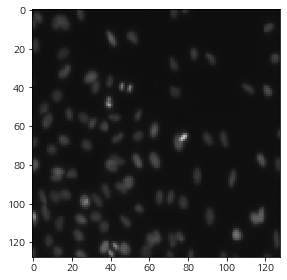

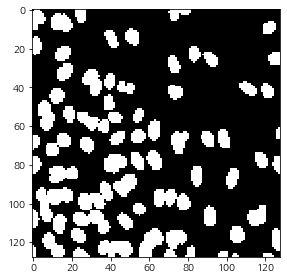

In [8]:
# 이제 무작위 image와 mask를 그려서 괜찮은 상황인지 보자.

# check
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow((np.squeeze(Y_train[ix])))
plt.show()


## 2. Keras metric 생성
이제 케라스에서 조합(IoU) 임계값 메트릭을 서로 다른 교차로에서 평균 정밀도를 정의하려고 한다.
텐서플로우는 평균 IoU 메트릭이 있지만 다중 임계값에 대한 평균에 대한 기본 지원이 없어 이를 구현하려고 했다.
(하지만 저자가 이 구현이 올바른지 결코 확신할 수 없는 점 참고바란다.)

업데이트: 여기에서 보고된 결과와 LB 결과 간의 차이가 매우 크기 때문에 이 구현이 가장 분명하지 않다.
그것은 또한 시간이 지남에 따라 당신이 언제 훈련을 받든 간에 증가하는 것처럼 보인다


In [9]:
# Define Iou  metric
def mean_iou(y_true, y_pred):
    prec =[]
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt= tf.metrics.mean_iou(y_true, y_pred, 2)
        tf.keras.backend.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)

    return tf.keras.backend.mean(tf.keras.backend.stack(prec), axis=0)


## 3. neural network 생성 및 훈련

In [10]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x/255) (inputs)

c1 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2)) (c1)

c2 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2)) (c2)

c3 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2)) (c3)

c4 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2,2)) (c4)

c5 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1,1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs = [outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()


Instructions for updating:
Use `tf.cast` instead.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
____________________________________

업데이트: ELU 유닛으로 변경, 중도 탈락 추가.

다음으로 0.1의 검증 분할을 사용하여 교육 데이터에 모형을 fit시킨다.
데이터가 너무 적기 때문에 작은 배치 크기를 사용한다. 모델을 훈련시킬 때 체크포인트와 조기 중지를 사용하는 것을 추천한다.
현재의 파라미터로 카글 커널에서 10분 정도 걸리는 10세기를 그냥 훈련시키겠다.

업데이트: 조기 정지 및 체크포인트 추가 및 30 epoch까지 증가.

In [11]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl201801.h5', verbose=1, save_best_only=True)
# epoch 50 -> 10
results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size=16, epochs=10,
                    callbacks=[earlystopper, checkpointer])


Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - ETA: 0s - loss: 0.4038 - mean_iou: 0.3904WARNING:tensorflow:From c:\users\hanbit\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 0.21397, saving model to model-dsbowl201801.h5
603/603 [==============================] - 67s 111ms/sample - loss: 0.4038 - mean_iou: 0.3904 - val_loss: 0.2140 - val_mean_iou: 0.3988
Epoch 2/10
603/603 [==============================] - ETA: 0s - loss: 0.1877 - mean_iou: 0.3998
Epoch 00002: val_loss improved from 0.21397 to 0.15014, saving model to model-dsbowl201801.h5
603/603 [==============================] - 67s 110ms/sa

- 10번의 시도 결과, loss 값은 계속 줄어들고 있음을 알 수있다.

## 4. 예측 모형 만들기

testset, trainset, valset 을 데이터를 이제 예측해보자.

In [13]:
# Predict on train, val and test
model = load_model('model-dsbowl201801.h5', custom_objects={'mean_iou':mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

In [14]:
# Treshold predictions (임계값 예측) : 0.5 이상인 값만 가져오겠다.
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [16]:
preds_test_unsampled = []
for i in range(len(preds_test)):
    preds_test_unsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                mode='constant', preserve_range=True))

    

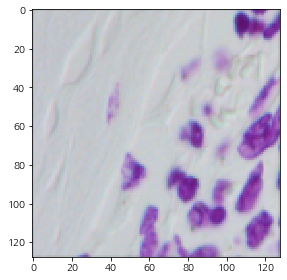

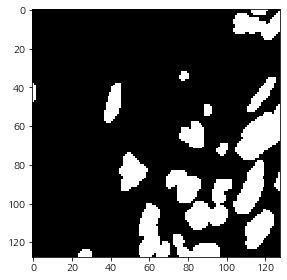

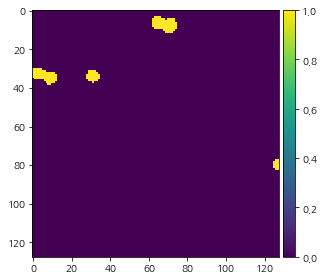

In [18]:
# 일부 랜덤 training 샘플이 맞는지 체크
ix = random.randint(0, len(preds_test_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

모델은 최소한 훈련 데이터에 접합할 수 있다. 여기서에도 개선해야할 점은 많겠지만 괜찮다.!! 검증데이터도 알아보자.

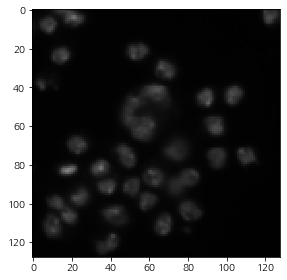

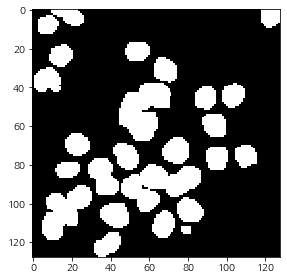

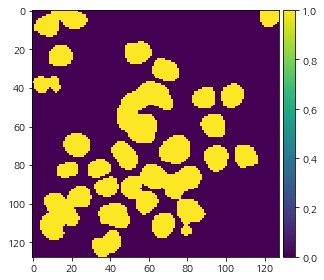

In [19]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

데이터가 나쁘진 않지만, 좀더 많은 training과 update가 필요할 것 같다.

## 5. 인코드, 결과물 제출하기

이제 결과를 제출하기 위해 encoding 작업을 해보자.
Run-length encoding stolen은 [이 사이트]( https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)에 잘나와있다. 

In [23]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() ==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1) : run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x>cutoff)
    for i in range(1, lab_img.max() +1):
        yield rle_encoding(lab_img == i)
    


자 이제 skimage에 의해 식별시키기 위해 testID와 일반 run-length 인코딩을 분리해보자. 

In [24]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_unsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

그리고 마침네 우리의 제출물을 만들자.

In [29]:
# 아래 코든느 제출 형식과 맞지 않아 패스!
# sub = pd.DataFrame()
# sub['ImageId'] = new_test_ids
# sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
# sub.to_csv('sub-dsvow12018-1.csv',index=False)